In [1]:
import os
import datetime

from pyonset import Onset, BootstrapWindow

# Import to enable the SEPPY drop-down menu
import seppy.tools.widgets as w

#### For this demonstration, we will choose from the drop-down menu the following options
> Spacecraft: Solar Orbiter

> Sensor: EPT

> Viewing: sun

> Species: proton

In [2]:
display(w.spacecraft_drop, w.sensor_drop, w.view_drop, w.species_drop)

Dropdown(description='Spacecraft:', options=('PSP', 'SOHO', 'Solar Orbiter', 'STEREO-A', 'STEREO-B', 'Wind'), …

Dropdown(description='Sensor:', options=('isois-epihi', 'isois-epilo'), value='isois-epihi')

Dropdown(description='Viewing:', options=('A', 'B'), value='A')

Dropdown(description='Species:', options=('protons', 'electrons'), value='protons')

In [3]:
# Values hard-coded here for the sake of example.
# Feel free to delete this cell in favor of the drop-down menu.
w.spacecraft_drop.value = "Solar Orbiter"
w.sensor_drop.value = "EPT"
w.view_drop.value = "sun"
w.species_drop.value = "electrons"

# The workflow for finding the onset time and accompanying uncertainty:

>1.) Initialize the `Onset` object with `spacecraft`, `sensor`, possible `viewing` and particle `species`. Also provide the `startdate` and `enddate`, to load the desired data in to the object.

>2.) Identify the background preceding the event by setting the `start` and `end` parameters for the `BootstrapWindow` object as pandas-compatible datetime strings. Then run `cusum_onset()` to check that the an onset is found and that the background is reasonable. This may require multiple tries. Also set the amount of `bootstrap` iterations to this object, which controls the amount of random samples that are taken from the background window.

>3.) Run the `print_max_recommended_reso()` -method for the background. It will print out the suggested maximum time-averaging that should be applied to the data in the next cell.

>4.) Set the `limit_averaging` variable to the suggested maximum time-averaging as a pandas-compatible time string, e.g., '5 min', if you want to preserve good statistics in all of the time-averaged versions of the data. Also set the `sample_size` to the fraction of the data points that should be taken for each of the random samples of the bootstrapping runs. Generally, the longer the background window, the smaller you may set the sample_size.

>4.) Run channelwise_onset_statistics() -method for the object. With (a) given channel(s) this will take random samples from the background and find a corresponding distribution of onset times. The width of the ~68 % confidence interval of this distribution in minutes, $\Delta \lfloor u_{1}^{1} \rfloor$, is the time resolution the method will suggest to average the data up to, in order to make additional distributions from lower time resolution versions of the data. 

>5.) Call the `onset_statistics` attribute of the `Onset` object. It is a dictionary, that holds the mode, the median, and the boundaries of the ~68 \% and ~95 \% confidence intervals, respectively. 

In [4]:
# The path to where data is located / to be downloaded (by default the current directory)
data_path = f"{os.getcwd()}{os.sep}data"

# Format of the dates: year, month, day
startdate, enddate = datetime.datetime(2021,10,27), datetime.datetime(2021,10,29)

# Select the color map used for the plot, by default 'magma'
# for avavailable options, cf. https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = 'magma'  # e.g. 'jet', 'viridis', 'magma'

# Initialize the Onset object:
The object initializator takes parameters from the drop-down menu, and the previous cell

In [5]:
onset = Onset(spacecraft=w.spacecraft_drop.value, sensor=w.sensor_drop.value, 
                    data_level='l2', species = w.species_drop.value,
                    start_date = startdate, end_date = enddate, viewing=w.view_drop.value,
                    data_path = data_path)

Creating dir /home/chospa/Documents/Github/hybrid_cusum/examples/data/l2/epd/ept/


solo_L2_epd-ept-asun-rates_20211027_V02.cdf: 1.62MB [00:01, 1.15MB/s]                                              
solo_L2_epd-ept-asun-rates_20211028_V02.cdf: 5.51MB [00:03, 1.78MB/s]                                              
solo_L2_epd-ept-asun-rates_20211029_V02.cdf: 12.2MB [00:05, 2.21MB/s]                                              
solo_L2_epd-ept-north-rates_20211027_V02.cdf: 1.62MB [00:00, 1.73MB/s]                                             
solo_L2_epd-ept-north-rates_20211028_V02.cdf: 5.89MB [00:02, 2.08MB/s]                                             
solo_L2_epd-ept-north-rates_20211029_V02.cdf: 14.3MB [00:06, 2.15MB/s]                                             
solo_L2_epd-ept-south-rates_20211027_V02.cdf: 1.60MB [00:01, 1.35MB/s]                                             
solo_L2_epd-ept-south-rates_20211028_V02.cdf: 5.19MB [00:02, 2.04MB/s]                                             
solo_L2_epd-ept-south-rates_20211029_V02.cdf: 12.9MB [00:05, 2.22MB/s]  

**A note about the print_energies() method:**

>The method print_energies() displays the `channel` number and the respective energy range for the instrument. Note that `channel` ids don't necessarily start from 0.

In [6]:
onset.print_energies()
%matplotlib inline

,Energy range
Channel,
0,0.0312 - 0.0354 MeV
1,0.0334 - 0.0374 MeV
2,0.0356 - 0.0396 MeV
3,0.0382 - 0.0420 MeV
4,0.0408 - 0.0439 MeV
5,0.0439 - 0.0467 MeV
6,0.0467 - 0.0505 MeV
7,0.0505 - 0.0542 MeV
8,0.0542 - 0.0588 MeV


**A note about `plot_range`, `background` and `erase`:**

> The `plot_range` is a list of two pandas-compatible datetime strings, e.g., '2012-12-31 13:37:00', which define the starting and ending position of the plot in the method `cusum_onset()`. If left to None, the entire data loaded into the `Onset` object will be displayed.

> The `background` variable is decklared as a `BootstrapWindow` object, which takes input `start` (str), `end` (str) and `bootstraps` (int). `start` and `end` define the starting and ending points of the background as pandas'compatible datetime strings, such as "2023-10-02 13:37:00", while `bootstraps` defines the amount of onsets searched per a distribution.

> The `erase` variable can be used to filter out clearly too high erroneous values from the background. It is a tuple/list of len()==2, that takes as its first entry the maximum allowed intensity value in the background. The second entry is a pandas-compatible datetime string, that defines the ending point of this filter. 

In [7]:
# The channels of any specific instrument can be displayed via print_energies() method
channel = 1

# The limits of the plot, and the limits of the background window.
# Argument 'bootstraps' in the BootstrapWindow object tells the amount of samples are taken from the background.
plot_range = None #["2022-01-20 00:00", "2022-01-20 05:00"]
background = BootstrapWindow(start="2021-10-27 09:00", end="2021-10-28 06:00", bootstraps=1000)

# A filter to erase erroneous values in the background (leave to None if not needed)
erase = None #[3e2, background.end]

# The time averaging, e.g., '2min'. Note that this applies only to the next cell, not to the statistic method.
averaging = "1 min"

# The amount of time, in minutes, that we demand for continuous threshold-exceeding intensity before identifying the onset of the event
cusum_minutes = 30

# Finding the event
**If statistical analysis is to be performed, make sure that the background does not overlap with the onset of the event**

>The `cusum_onset()` applies the traditional Poisson-CUSUM method to the data, and finds exactly one onset time that corresponds to the
$(\mu,\sigma)$ pair that describes the data point population inside the background. It returns a list of `single_onset_stats` and the `flux_series`, which
is simply the time series that is plotted on the figure. The `single_onset_stats` list includes the mean, mean + 2$\cdot$std, k rounded to nearest integer, h, z-standardized intensity time series, the CUSUM function and the onset time. 

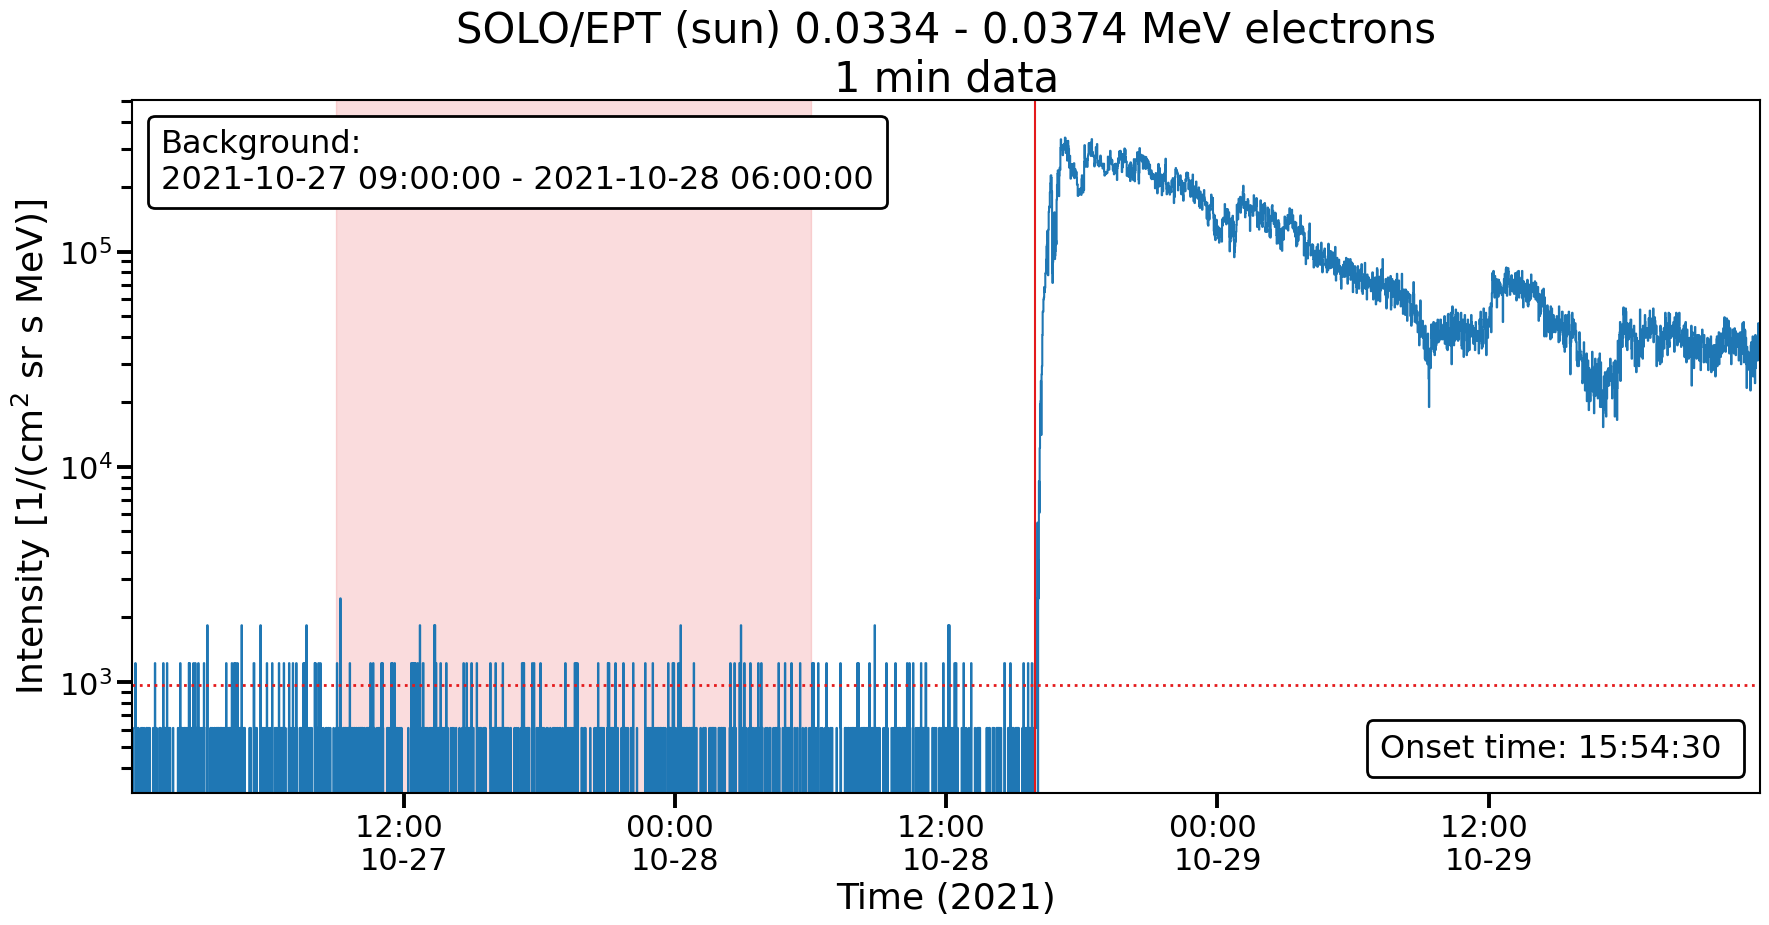

In [8]:
#
single_onset_stats, flux_series = onset.cusum_onset(channels=channel, background_range=background, xlim=plot_range, viewing=w.view_drop.value,
                                             resample=averaging, erase=erase, cusum_minutes=cusum_minutes)

In [9]:
# This method of the background object suggests the time-averaging to which one should limit the method to.
background.print_max_recommended_reso()

Your chosen background is 1260 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 12 minutes or enlarge the background window.


In [10]:
# The method averages data, by default, up to the ~68 % uncertainty of the native data resolution. However, we 
# strongly urge the user to limit the averaging to at most to the recommendation given in the previous cell,
# in order to not have too few data points in the background to calculate CUSUM parameters from
limit_averaging = "12 min"

# Acquiring most likely onset time and its uncertainty
**The cells below perform the statistical Poisson-CUSUM bootstrap hybrid onset evaluation automatically to all available energy channels, and stores the results in the object.**

**About the onset_statistics_per_channel() -method:**

>This method runs the cusum_onset() -method for the native data resolution of the given instrument for the amount of times stated in the `BootstrapWindow` -object's attribute `bootstraps`. From the uncertainty derived from the yielded onset distribution, the method proceeds to average the time series data and produce sets of onset distributions with 1 minute intervals up to that uncertainty in minutes.

>The method can be run for a single channel (int), a list of channels, or to all possible channels by giving `channels='all'` as an input.

>For example: the ~68 % confidence interval of channel X is 10 minutes. The method will proceed to average the time series data up to 10 minutes, creating 10 sets of the same data with progressively coarser time resolution from 1 minute to 10 minutes. Each set will contain a distribution of `bootstraps` amount of onset times, ultimately adding up to `bootstraps` $\cdot$ $\Delta u_{1}^{1}$ individual onset times.

>Ultimately from the sets of distributions created the method calculates a weighted average for the mode, median, ~68 % confidence interval and ~95 % confidence interval for the onset times. These timestamps are stored in the object's dictionary `onset_statistics`, which can be called when the method has been run. If the user should run the method for another channel, this channel's statistics are also saved into this dictionary.

> Note that for Solar Orbiter's and Wind's instruments this method will always average the data to 1 min resolution at the start, unless explicitly told not to with `limit_computation_time=False`, due to the exceptionally fine cadence of the instruments (1 s and 12 s). Limiting computation time also has the effect of producing less distributions past the 10 min time resolution, such that only every 5 minutes integration times are used past 10 minute integration time, i.e., (..8, 9, 10, 15, 20, 25, ...)


The `onset_statistics_per_channel()` method returns a `np.ndarray` that holds `OnsetsStatsArray` objects, one object for each of the channels that the method was run for. Each of these objects, which are stored in `uncertainty_stats_by_channel`, stores the statistics and plots corresponding to their respective channel's sets of distributions.

In [11]:
# The portion of the bootstrap sample that the method randomly picks from the background
sample_size = 0.55

# This switch controls intermediate notification being printed by channelwise_onset_statsistics(), e.g., to which time should the averaging me limited to,
# and which channel is being handled
print_output = True

# Sometimes no onset is found no matter the random sample in the native time resolution of the data. However, further time-averaging may reveal the onset
# of the event such that it can be found. This parameter controls to how long of a time-averaging, in minutes, should the method keep trying before 
# giving up on finding any onset times.
fail_avg_stop = 6

**About the `OnsetsStatsArray` object:**


`OnsetStatsArray` object's attributes can be listed with the method `.attrs()`. It also has methods to visualize data, such as:

>`.integration_time_plot()`, that shows the mean, median, and mode onsets, and $\sim$68 % and $\sim$95 % confidence intervals corresponding to each distribution of onset times as a function of time resolution.

>`.show_onset_distribution()` displays the full distribution of onset times of a single set marked with vertical lines on the time series data. The most popular onset time (highest frequency in the distribution) is drawn with a solid line, while the rest of the unique onset times are drawn with dashed lines. The less popular onset times appear with a lighter shade than those with higher popularity.

>`.show_onset_statistics()` is very much like the aforementioned method, but instead of the distribution, it displays the mode, median and mean onset times drawn on the time series, accompanied by the $\sim$68 % and $\sim$95 % confidence intervals with a light shading of red and blue, respectively.

In [12]:
# The method below returns a list (with len==1) named uncertainty_stats_per_channel, that holds a single OnsetStatsArray inside it.
# This OnsetStatsArray object holds all the statistics of the onset related to the channel that was previously run.

uncertainty_stats_by_channel = onset.onset_statistics_per_channel(channels=channel, background=background, viewing=w.view_drop.value, erase=erase,
                                                                  cusum_minutes=cusum_minutes, sample_size=sample_size, print_output=print_output, 
                                                                  limit_averaging=limit_averaging, fail_avg_stop=fail_avg_stop)


Your chosen background is 1260 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 12 minutes or enlarge the background window.
Channel 1:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes


`onset_statistics` is a dictionary, that maps each channel number to a list that contains the timestamps: [mean, median, ($\sim$68 % lower bound), ($\sim$68 % upper bound), ($\sim$95 % lower bound), ($\sim$95 % upper bound)]

In [14]:
onset.onset_statistics

{1: [Timestamp('2021-10-28 15:54:30.506807168'),
  Timestamp('2021-10-28 15:54:30.506807168'),
  Timestamp('2021-10-28 15:54:00.506807168'),
  Timestamp('2021-10-28 15:55:00.506807296'),
  Timestamp('2021-10-28 15:54:00.506807168'),
  Timestamp('2021-10-28 15:55:00.506807296')]}

# Results
**In the next cell one can visualize the different statistics of the automatic process, such as the uncertainty of the onset as a function of averaging, the distribution of onset times on the time series and the mean, median and mode of the distribution**

> The methods `.show_onset_distribution()` and `.show_onset_statistics()` accept the optional arguments `xlim` and `integration_time_index`.

>`xlim` is a pair of pandas-compatible time strings, that define the limits of the x-axis in the plots.

>`integration_time_index` is an integer that defines which of the time-averaged sets of distributions is displayed in the figure. By default, the time series, distribution and statistics for the native data resolution is displayed, which corresponds to `integration_time_index==0`.

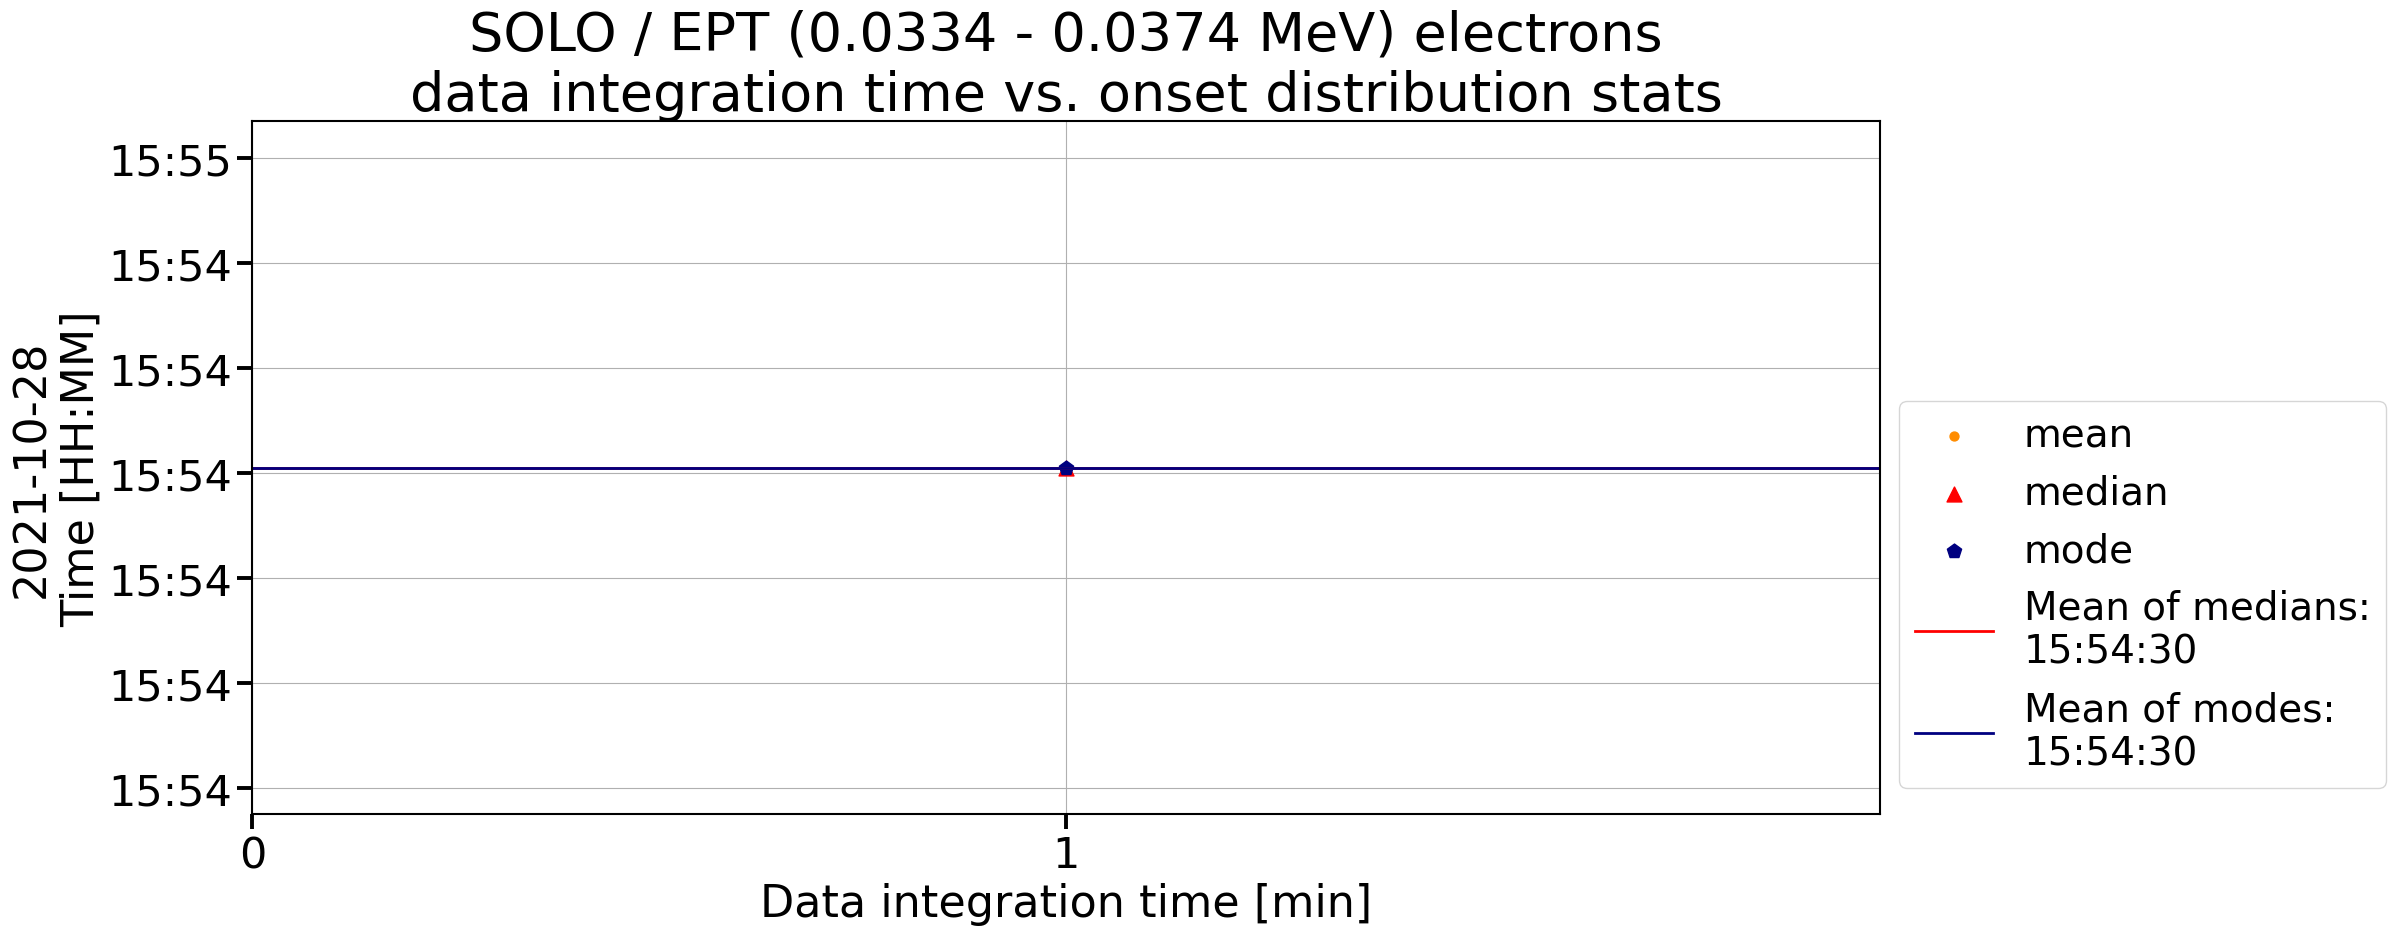

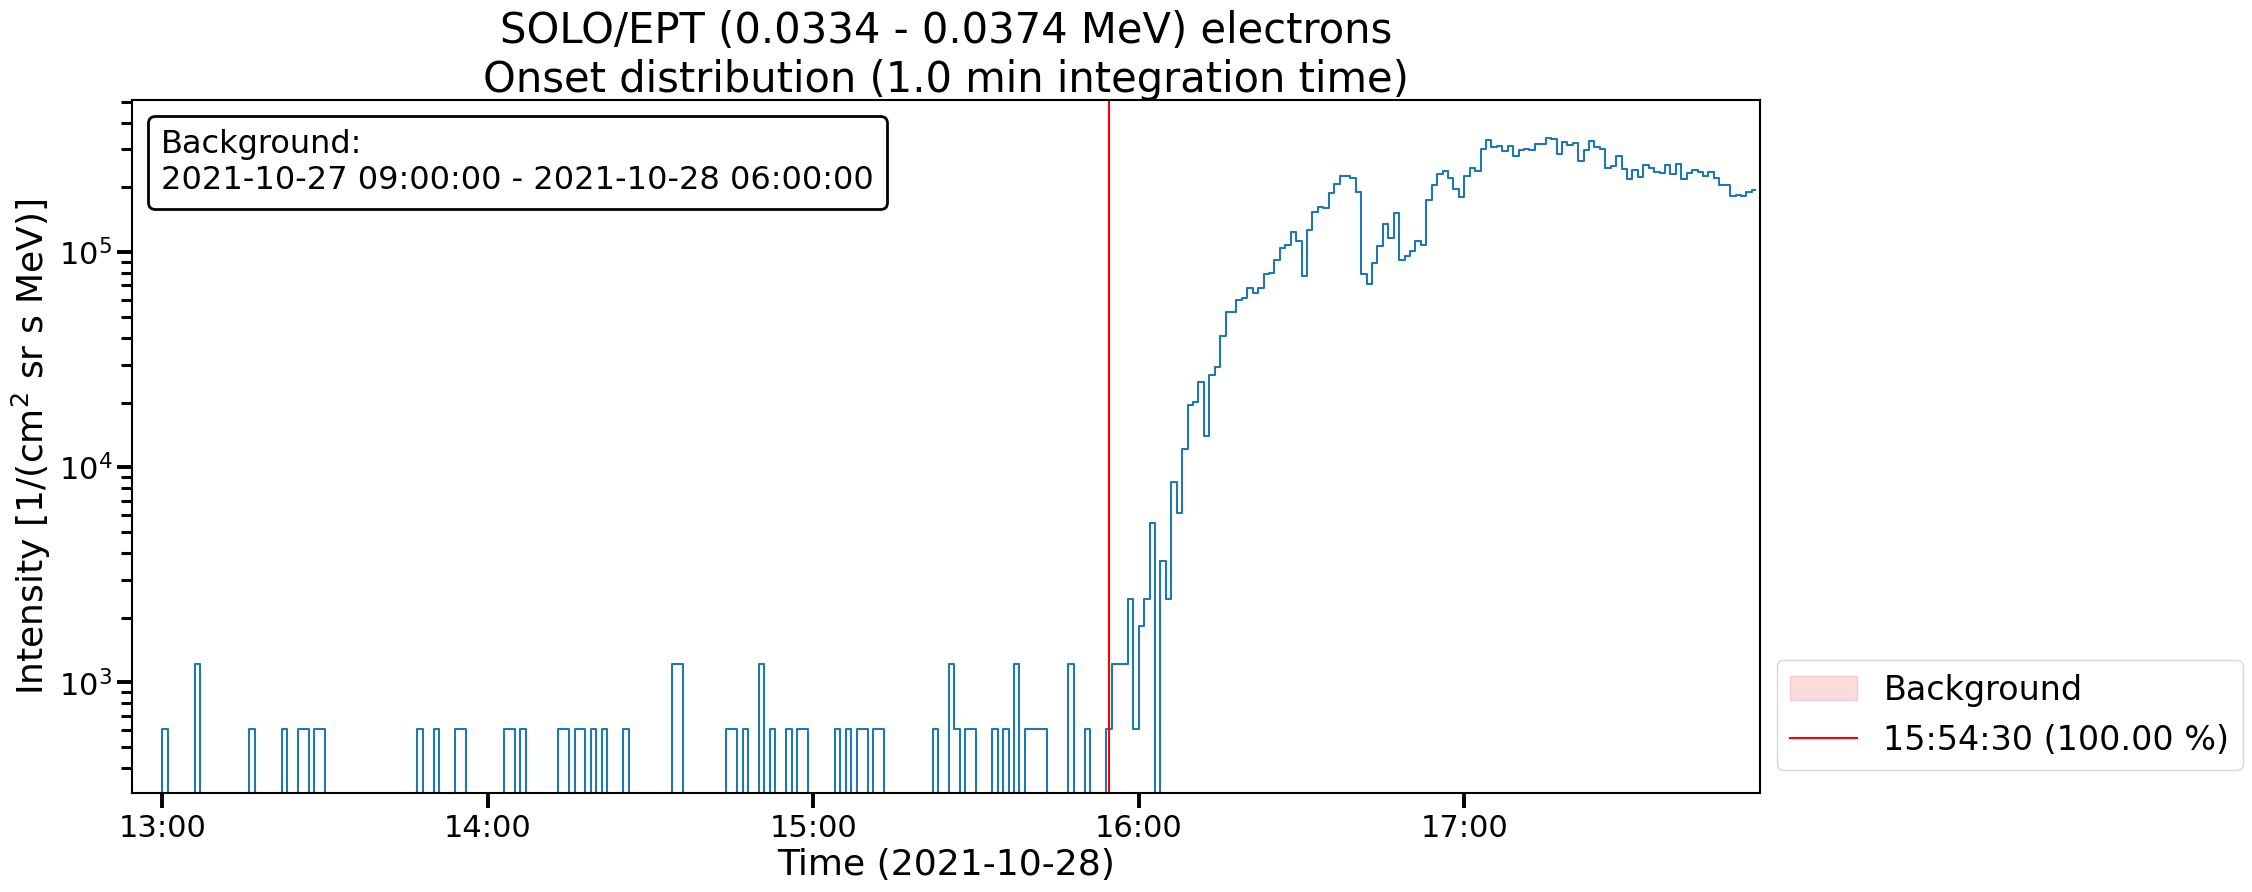

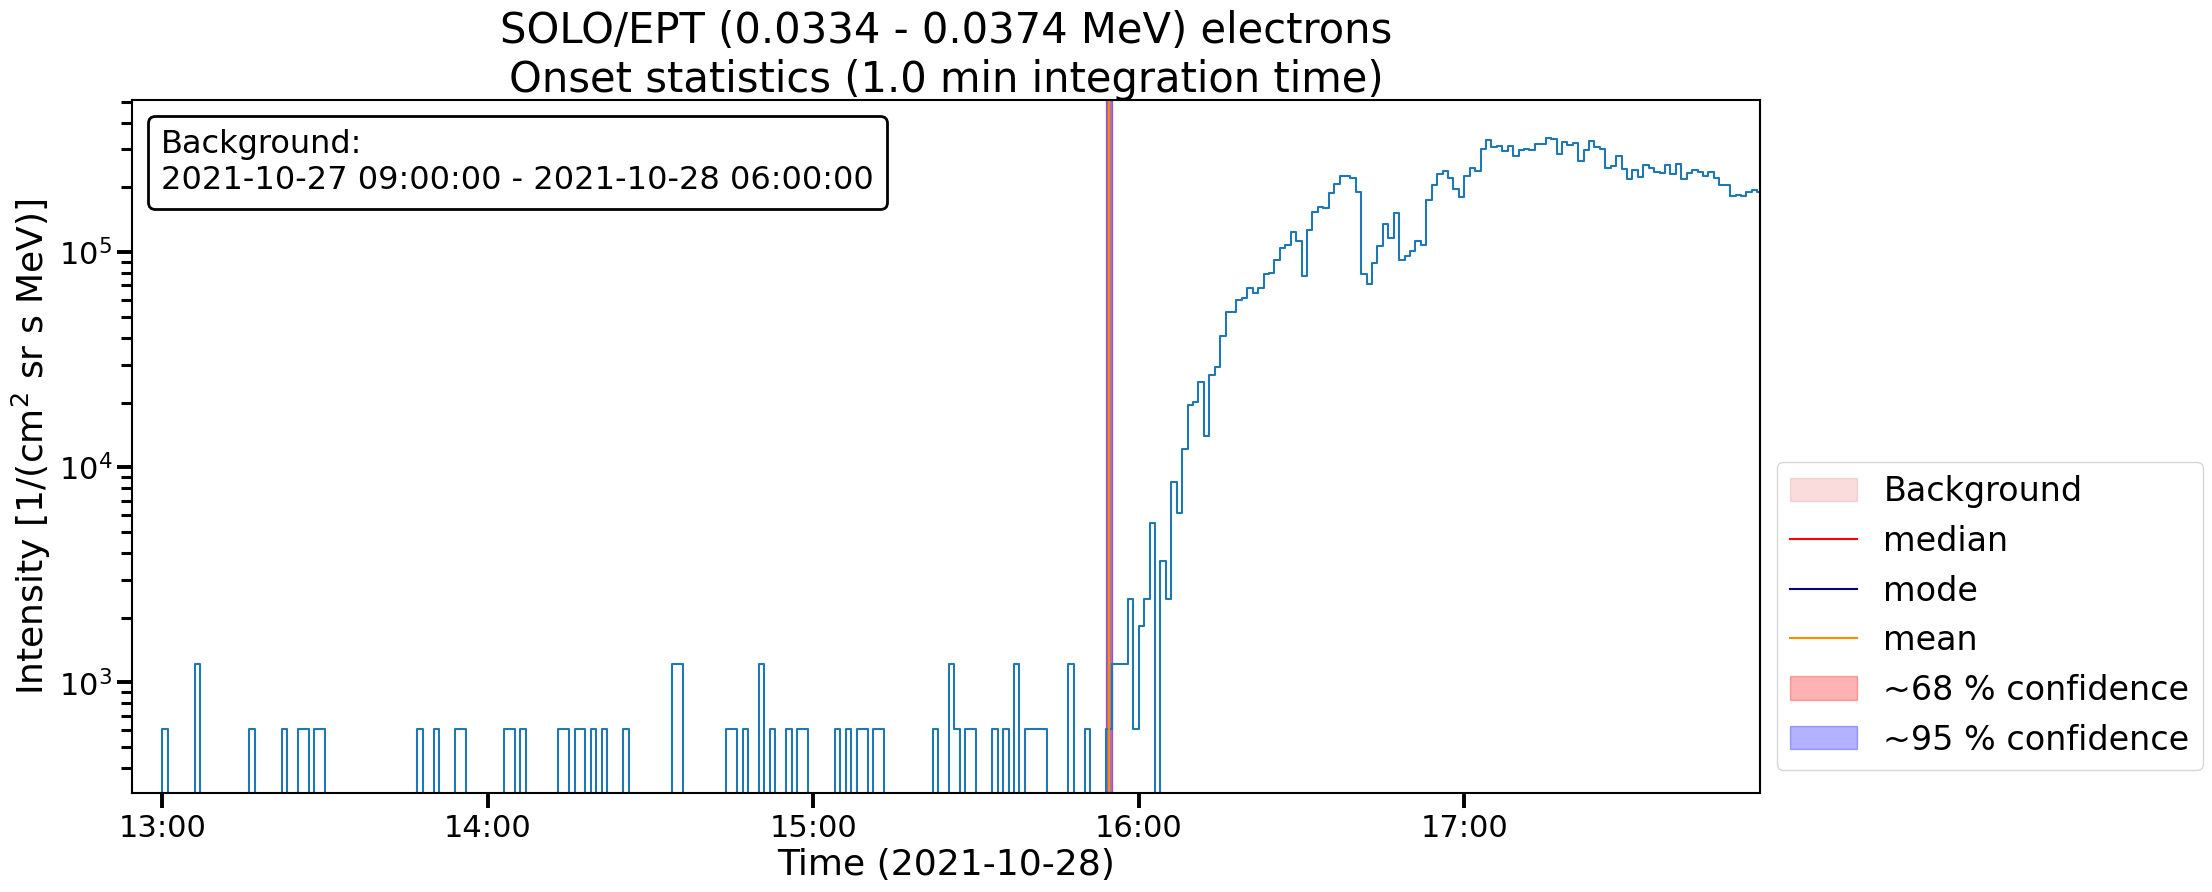

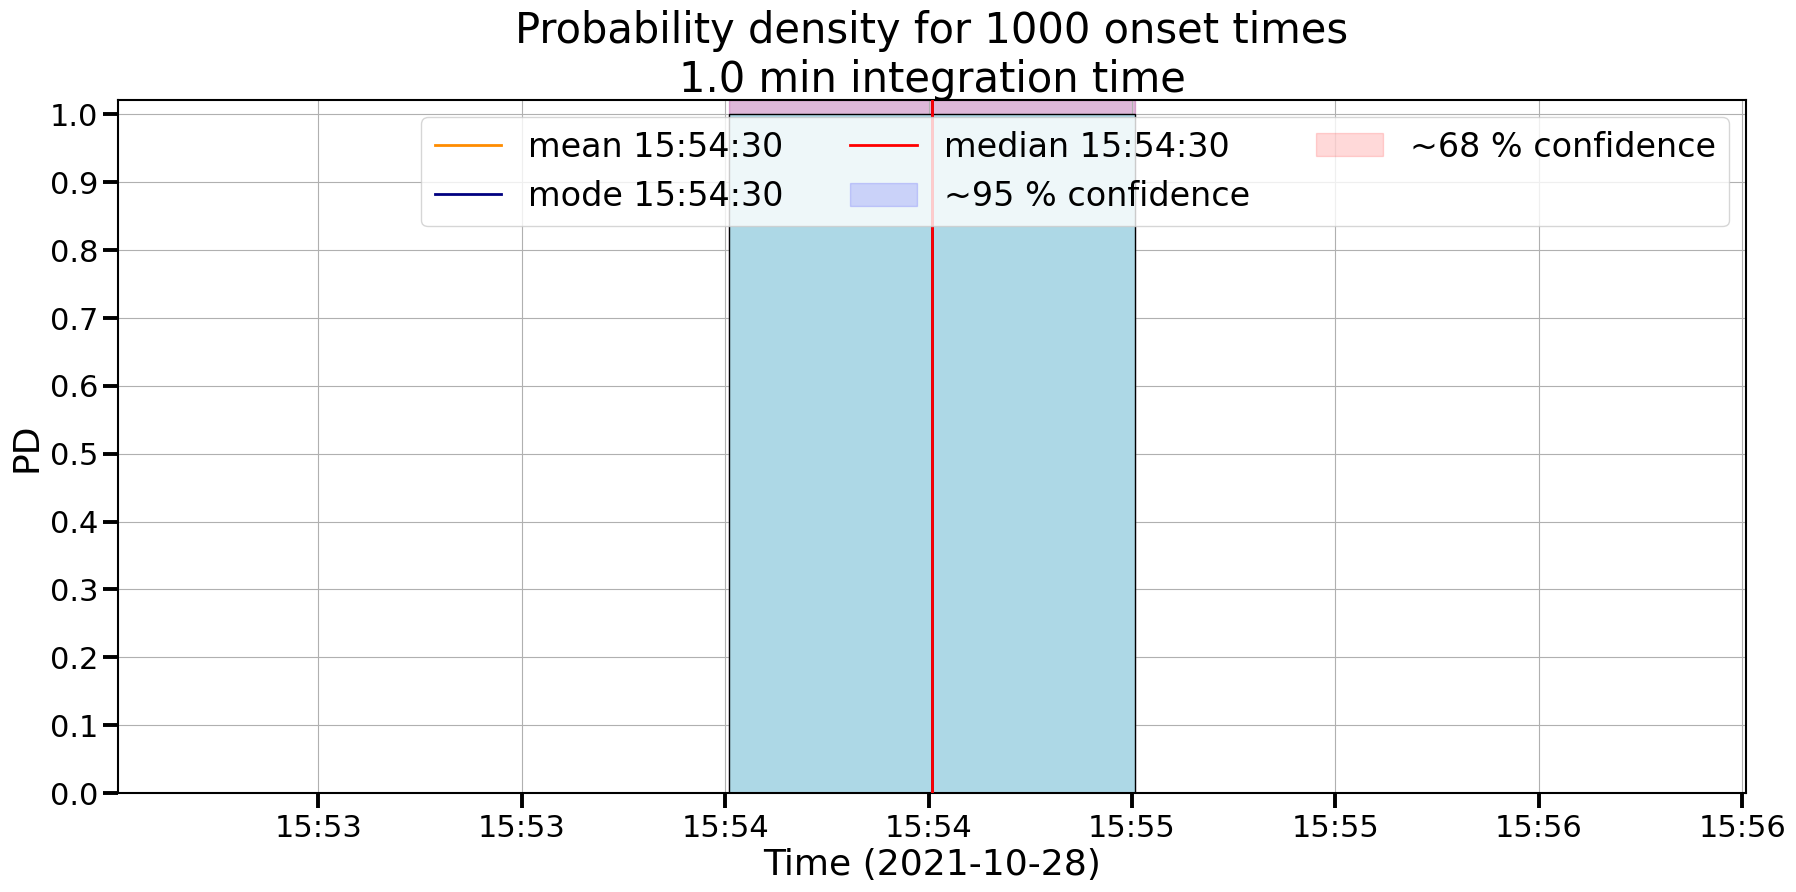

In [15]:
# The index of the channel
channel_index = 0

uncertainty_stats_by_channel[channel_index].integration_time_plot()
uncertainty_stats_by_channel[channel_index].show_onset_distribution(integration_time_index=0, xlim=None)
uncertainty_stats_by_channel[channel_index].show_onset_statistics(integration_time_index=0, xlim=None)
uncertainty_stats_by_channel[channel_index].onset_time_histogram(integration_time_index=0, xlim=None)

#  The onset time as a function energy

In order to perform velocity dispersion analysis (VDA), we are going to need a range of onset times at different energies. In the next cells we repeat the process above for all available energy channels of this instrument
The `onset_statistics_per_channel()` -method accepts integers, tuples, lists and ranges as an input for the parameter `channels`. Passing the string 'all' as an input runs the method for all available channels in the `Onset` object's memory.

In [16]:
# Run the method with the same input as before, but this time pass channels='all' to repeat 
# the onset time and uncertainty evaluation for all available channels
channels = "all"

uncertainty_stats_by_channel = onset.onset_statistics_per_channel(channels=channels, background=background, viewing=w.view_drop.value, erase=erase,
                                                                  cusum_minutes=cusum_minutes, sample_size=sample_size, print_output=print_output, 
                                                                  limit_averaging=limit_averaging, fail_avg_stop=fail_avg_stop)

Your chosen background is 1260 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 12 minutes or enlarge the background window.
Channel 0:
Channel 1:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes
Channel 2:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes
Channel 3:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes
Channel 4:
~68 % uncertainty for the self time with native data resolution: 0 days 00:03:00
Averaging up to 3 minutes
Channel 5:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes
Channel 6:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes
Channel 7:
~68 % uncertainty for the self time with native data resolution: 

In [17]:
# The onset_statistics dictionary is automatically updated
onset.onset_statistics

{1: [Timestamp('2021-10-28 15:54:30.506807168'),
  Timestamp('2021-10-28 15:54:30.506807168'),
  Timestamp('2021-10-28 15:54:00.506807168'),
  Timestamp('2021-10-28 15:55:00.506807296'),
  Timestamp('2021-10-28 15:54:00.506807168'),
  Timestamp('2021-10-28 15:55:00.506807296')],
 0: [NaT, NaT, NaT, NaT, NaT, NaT],
 2: [Timestamp('2021-10-28 15:49:30.506807168'),
  Timestamp('2021-10-28 15:49:30.506807168'),
  Timestamp('2021-10-28 15:49:00.506807168'),
  Timestamp('2021-10-28 15:50:00.506807296'),
  Timestamp('2021-10-28 15:49:00.506807168'),
  Timestamp('2021-10-28 15:50:00.506807296')],
 3: [Timestamp('2021-10-28 15:50:30.506807168'),
  Timestamp('2021-10-28 15:50:30.506807168'),
  Timestamp('2021-10-28 15:50:00.506807168'),
  Timestamp('2021-10-28 15:51:00.506807296'),
  Timestamp('2021-10-28 15:50:00.506807168'),
  Timestamp('2021-10-28 15:51:00.506807296')],
 4: [Timestamp('2021-10-28 15:52:16.269396598'),
  Timestamp('2021-10-28 15:52:05.495793392'),
  Timestamp('2021-10-28 15:50

# Velocity dispersion analysis:

**With an onset time and its uncertainty found in varying energy ranges, one can run the VDA()-method.**

The `.VDA()` -method automatically uses the mode onset times and uncertainties stored in the `Onset` object's memory. It applies a first order polynomial fit using a orthogonal distance regression algorithm to the onset times as a function of the inverse unitless speed $1/\beta = c/v$, where $c$ is the speed of light.

The method returns a dictionary that holds the values for inverse betas, errors in x and y-directions (energy and time), onset times used, the path length and injection time that the fit yields, the uncertainties related to the path length and injection time, the chi squared of the fit, reason that the ODR algorithm stopped, the figure and its axes.

In [28]:
selection = slice(1,33)

vda_output = onset.VDA(selection=selection, grid=False)

/home/chospa/anaconda3/envs/pyonset/lib/python3.12/site-packages/pyonset/__init__.py:4423: UserWarning: Discarding nonzero nanoseconds in conversion.
  dates_in_sec.append((date.to_pydatetime() - datetime.datetime(1970,1,1,0,0,0)).total_seconds())
/home/chospa/anaconda3/envs/pyonset/lib/python3.12/site-packages/matplotlib/cbook.py:1709: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


In [22]:
vda_output

{'inverse_beta': masked_array(data=[--, 2.826199303483831, 2.7502166044451872,
                    2.6717318013817595, 2.6071116748833174,
                    2.5305071674587913, 2.45408913739198,
                    2.3760947449147074, 2.2997723324843227,
                    2.2238332942783336, 2.1558338393699277,
                    2.089302869968094, 2.0235058714228016,
                    1.9601735035253018, 1.8971351906603706,
                    1.8377032144649401, 1.7823664147917344,
                    1.7279353400556594, 1.6751788607052909,
                    1.6254813334267055, 1.5797704275622415,
                    1.5368187174503714, 1.4940657281478258,
                    1.454969213274617, 1.4192611912952575,
                    1.3845526402689177, 1.352093553237013,
                    1.3216366828383213, 1.2937408603703369,
                    1.2673250777918876, 1.241781610662507,
                    1.2188689688195427, 1.1980560554584974,
                    1.17868

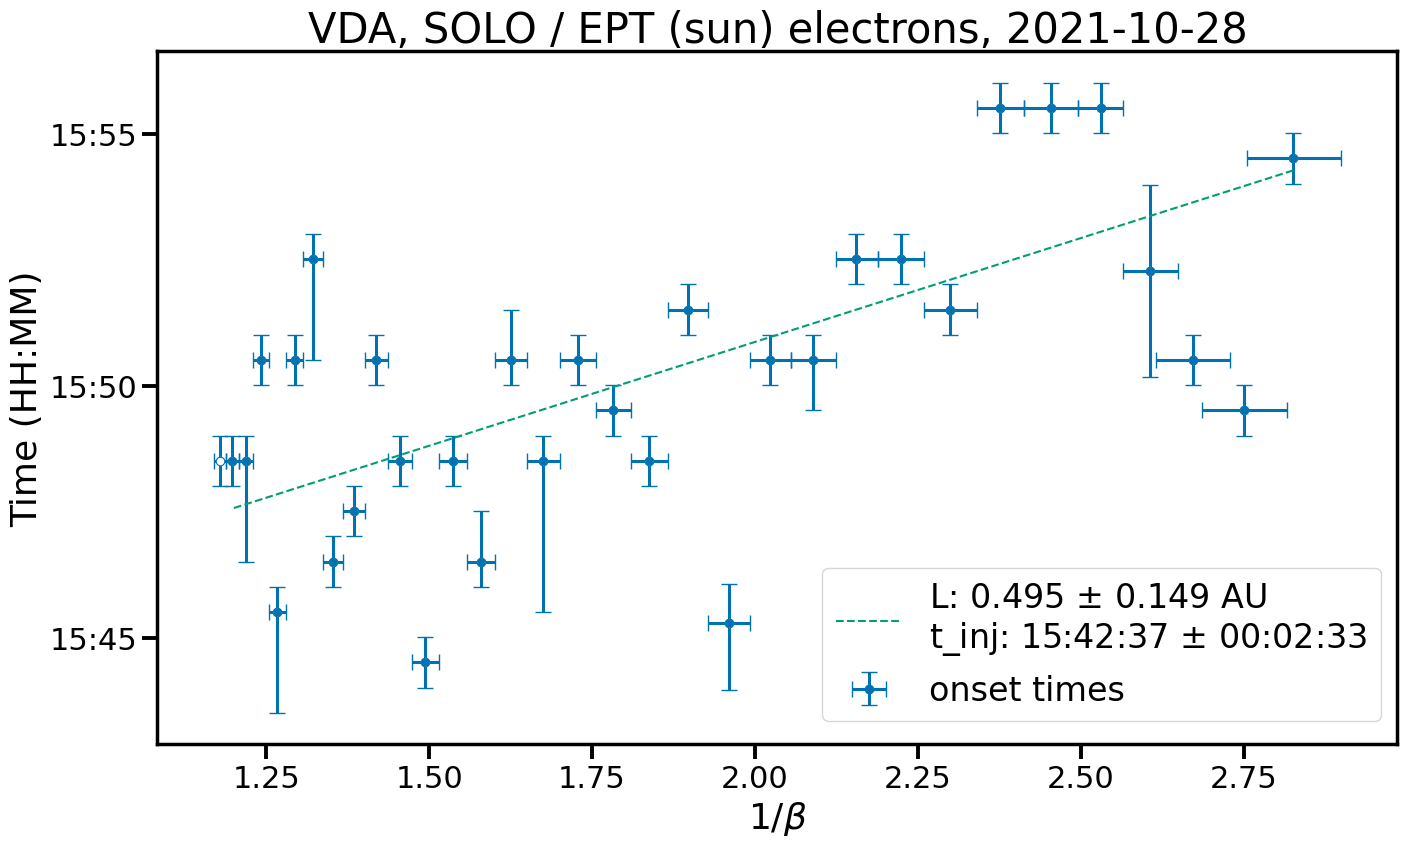

In [27]:
vda_output["fig"]